In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('operations').getOrCreate()

In [2]:
# read csv.
dfs = spark.read.csv('dataset/spam.csv', inferSchema=True, header=True)


In [3]:
# show columns and structure
dfs.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- word_freq_make: double (nullable = true)
 |-- word_freq_address: double (nullable = true)
 |-- word_freq_all: double (nullable = true)
 |-- word_freq_3d: double (nullable = true)
 |-- word_freq_our: double (nullable = true)
 |-- word_freq_over: double (nullable = true)
 |-- word_freq_remove: double (nullable = true)
 |-- word_freq_internet: double (nullable = true)
 |-- word_freq_order: double (nullable = true)
 |-- word_freq_mail: double (nullable = true)
 |-- word_freq_receive: double (nullable = true)
 |-- word_freq_will: double (nullable = true)
 |-- word_freq_people: double (nullable = true)
 |-- word_freq_report: double (nullable = true)
 |-- word_freq_addresses: double (nullable = true)
 |-- word_freq_free: double (nullable = true)
 |-- word_freq_business: double (nullable = true)
 |-- word_freq_email: double (nullable = true)
 |-- word_freq_you: double (nullable = true)
 |-- word_freq_credit: double (nullable = true)
 |-- word_freq_

In [4]:
# randomly select some columns to see summary
dfs.describe('capital_run_length_total', 'capital_run_length_longest', 'capital_run_length_average').show()


+-------+------------------------+--------------------------+--------------------------+
|summary|capital_run_length_total|capital_run_length_longest|capital_run_length_average|
+-------+------------------------+--------------------------+--------------------------+
|  count|                    4601|                      4601|                      4601|
|   mean|      283.28928493805694|         52.17278852423386|         5.191515105411881|
| stddev|       606.3478507248461|        194.89130952646354|         31.72944874021063|
|    min|                       1|                         1|                       1.0|
|    max|                   15841|                      9989|                    1102.5|
+-------+------------------------+--------------------------+--------------------------+



In [5]:
# check missing value
from pyspark.sql.functions import isnan, when, count, col

dfs.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfs.columns]).show()


+---+--------------+-----------------+-------------+------------+-------------+--------------+----------------+------------------+---------------+--------------+-----------------+--------------+----------------+----------------+-------------------+--------------+------------------+---------------+-------------+----------------+--------------+--------------+-------------+---------------+------------+-------------+----------------+-------------+-------------+--------------+----------------+-------------+--------------+-------------+------------+--------------------+--------------+---------------+------------+----------------+------------+-----------------+------------------+-----------------+------------+-------------+---------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------------+--------------------------+------------------------+----------+---------+-----+
|_c0|word_freq_make|word_freq_address|word_fre

In [6]:
# fill up missing value with column mean
from pyspark.sql.functions import mean

mean_make = dfs.select(mean(dfs.word_freq_make)).collect()[0][0]
mean_receive = dfs.select(mean(dfs.word_freq_receive)).collect()[0][0]
mean_all = dfs.select(mean(dfs.word_freq_all)).collect()[0][0]

mean = {'word_freq_make': mean_make, 'word_freq_receive': mean_receive, 'word_freq_all': mean_all}
dfs = dfs.na.fill(mean)

dfs.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfs.columns]).show()

+---+--------------+-----------------+-------------+------------+-------------+--------------+----------------+------------------+---------------+--------------+-----------------+--------------+----------------+----------------+-------------------+--------------+------------------+---------------+-------------+----------------+--------------+--------------+-------------+---------------+------------+-------------+----------------+-------------+-------------+--------------+----------------+-------------+--------------+-------------+------------+--------------------+--------------+---------------+------------+----------------+------------+-----------------+------------------+-----------------+------------+-------------+---------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------------+--------------------------+------------------------+----------+---------+-----+
|_c0|word_freq_make|word_freq_address|word_fre

In [9]:
# create backup df for outlier analysis
dfs_outlier = dfs

drop_list = ['word_trial', 'word_test']

dfs_outlier = dfs_outlier.select([column for column in dfs.columns if column not in drop_list])

bounds = {
    c: dict(
        zip(["q1", "q3"], dfs_outlier.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in dfs_outlier.columns
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
    

for i in dfs_outlier.schema.names:
    print(i + ": " + str(bounds[i]))
    print("")

_c0: {'lower': -2299.0, 'upper': 6901.0, 'q1': 1151.0, 'q3': 3451.0}

word_freq_make: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_address: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_all: {'lower': -0.63, 'upper': 1.05, 'q1': 0.0, 'q3': 0.42}

word_freq_3d: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_our: {'lower': -0.585, 'upper': 0.975, 'q1': 0.0, 'q3': 0.39}

word_freq_over: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_remove: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_internet: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_order: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_mail: {'lower': -0.24, 'upper': 0.4, 'q1': 0.0, 'q3': 0.16}

word_freq_receive: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_freq_will: {'lower': -1.2000000000000002, 'upper': 2.0, 'q1': 0.0, 'q3': 0.8}

word_freq_people: {'lower': 0.0, 'upper': 0.0, 'q1': 0.0, 'q3': 0.0}

word_f

In [10]:
# check mean
dfs_outlier.describe('word_freq_make', 'word_freq_all', 'word_freq_receive', 'word_freq_you', 'char_freq_%24').show(2)

+-------+-------------------+-------------------+--------------------+------------------+-------------------+
|summary|     word_freq_make|      word_freq_all|   word_freq_receive|     word_freq_you|      char_freq_%24|
+-------+-------------------+-------------------+--------------------+------------------+-------------------+
|  count|               4601|               4601|                4601|              4601|               4601|
|   mean|0.10462157459765113|0.28077843009349784|0.059836956521739114|1.6620995435774817|0.07581069332753756|
+-------+-------------------+-------------------+--------------------+------------------+-------------------+
only showing top 2 rows



In [11]:
# import v2 csv and check missing value
from pyspark.sql.functions import isnan, when, count, col


dfs1 = spark.read.csv('dataset/spamV1.csv', inferSchema=True, header=True)

dfs1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfs1.columns]).show()

+---+--------------+-----------------+-------------+------------+-------------+--------------+----------------+------------------+---------------+--------------+-----------------+--------------+----------------+----------------+-------------------+--------------+------------------+---------------+-------------+----------------+--------------+--------------+-------------+---------------+------------+-------------+----------------+-------------+-------------+--------------+----------------+-------------+--------------+-------------+------------+--------------------+--------------+---------------+------------+----------------+------------+-----------------+------------------+-----------------+------------+-------------+---------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------------+--------------------------+------------------------+----------+---------+-----+
|_c0|word_freq_make|word_freq_address|word_fre

In [12]:
# fill missing value
from pyspark.sql.functions import mean

mean_make = dfs1.select(mean(dfs1.word_freq_make)).collect()[0][0]
mean_receive = dfs1.select(mean(dfs1.word_freq_receive)).collect()[0][0]

mean = {'word_freq_make': mean_make, 'word_freq_receive': mean_receive}
dfs1 = dfs1.na.fill(mean)

dfs1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfs1.columns]).show()

+---+--------------+-----------------+-------------+------------+-------------+--------------+----------------+------------------+---------------+--------------+-----------------+--------------+----------------+----------------+-------------------+--------------+------------------+---------------+-------------+----------------+--------------+--------------+-------------+---------------+------------+-------------+----------------+-------------+-------------+--------------+----------------+-------------+--------------+-------------+------------+--------------------+--------------+---------------+------------+----------------+------------+-----------------+------------------+-----------------+------------+-------------+---------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------------+--------------------------+------------------------+----------+---------+-----+
|_c0|word_freq_make|word_freq_address|word_fre

In [13]:
# combine two csvs
print("Number of rows for version 1: ", dfs.count())
print("Number of rows for version 2: ", dfs1.count())

dfs_combine = dfs.union(dfs1)
print("Number of rows for combined dataframe: ", dfs_combine.count())

Number of rows for version 1:  4601
Number of rows for version 2:  3101
Number of rows for combined dataframe:  7702


In [18]:
# example checking outliers for full version

df = dfs_combine.toPandas()

out_list = []
out_list2 = []


d = df['word_freq_000'].astype(int)
for i in range(0, len(d)):
    out_list.append(df['word_freq_000'][i])
    out_list2.append(df['word_freq_000'][i])
out_list.sort()
# print(out_list)
q1, q3 = np.percentile(out_list, [25, 75])

iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print("lower bound: ", lower_bound)
print("upper bound: ", upper_bound)

outliers = []
for i in range(0, len(d)):
    if out_list2[i] > upper_bound or out_list2[i] < lower_bound:
        outliers.append(out_list2[i])
print("")
print("Number of outliers for '000': ", len(outliers))

lower bound:  0.0
upper bound:  0.0

Number of outliers for '000':  1320


In [19]:
# drop unnecessary column
print("Before drop: ", len(dfs_combine.columns))

dfs_combine = dfs_combine.drop('capital_run_length_average')

print("After drop: ", len(dfs_combine.columns))

Before drop:  61
After drop:  60


In [20]:
# encode string columns to int
from pyspark.ml.feature import StringIndexer


indexer = StringIndexer(inputCol="word_trial", outputCol="trial_Index")
indexed = indexer.fit(dfs_combine).transform(dfs_combine)

indexer2 = StringIndexer(inputCol="word_test", outputCol="test_Index")
indexed = indexer2.fit(indexed).transform(indexed)

indexed = indexed.drop('word_test')
indexed = indexed.drop('word_trial')
indexed.describe('trial_Index', 'test_Index').show()

+-------+------------------+-------------------+
|summary|       trial_Index|         test_Index|
+-------+------------------+-------------------+
|  count|              7702|               7702|
|   mean|0.2455206439885744|0.25772526616463254|
| stddev|0.6281622210078537| 0.6443561320528145|
|    min|               0.0|                0.0|
|    max|               3.0|                3.0|
+-------+------------------+-------------------+



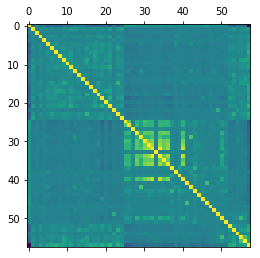

In [22]:
# show feature correlations
df = dfs_combine.toPandas()

import matplotlib.pyplot as plt

plt.matshow(df.corr())
plt.show()

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


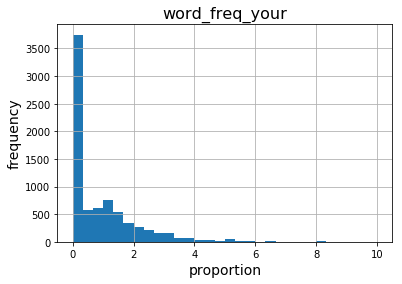

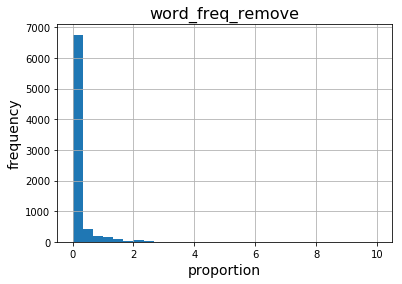

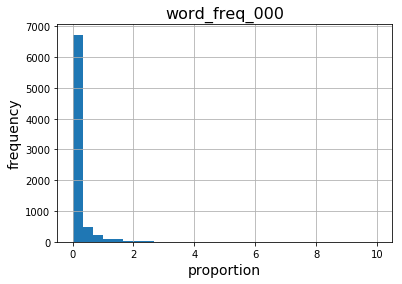

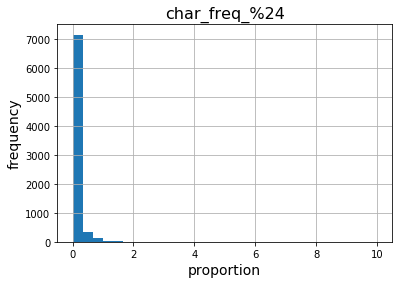

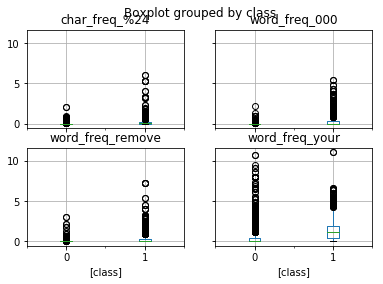

In [24]:
# plot class distribution for some features
vec = ["word_freq_your", "word_freq_remove", "word_freq_000", "char_freq_%24"]

for i in vec:
    df[i].hist(bins=30, range=[0, 10])
    plt.title(i, fontsize=16)
    plt.xlabel('proportion', fontsize=14)
    plt.ylabel('frequency', fontsize=14)
    plt.show()

# df['capital_run_length_average'].hist(bins = 30, range = [0, 10])
# plt.title('capital_run_length_average', fontsize = 16)
# plt.xlabel('proportion', fontsize = 14)
# plt.ylabel('frequency', fontsize = 14)
# plt.show()
# !pip3 install seaborn
# import seaborn as sb
# sb.set_style('darkgrid')
# sb.boxplot(data = df, y = 'capital_run_length_average')
# plt.show()


df1 = df[["word_freq_your", "word_freq_remove", "word_freq_000", "char_freq_%24", 'class']]

# print(df1)

boxplot = df1.boxplot(by='class')



In [25]:
# drop this feature becasue it has the lowest correlation among others, also drop id column
indexed = indexed.drop('word_freq_font')

indexed = indexed.drop('_c0')

In [26]:
# get features and label ready for building models

indexed_features = []
indexed_features = indexed.columns[0:54]

# print(indexed_features)
indexed_features.append('trial_Index')
indexed_features.append('test_Index')

from pyspark.ml.feature import  StringIndexer, VectorAssembler

stages = []

label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
stages += [label_stringIdx]

assembler = VectorAssembler(inputCols=indexed_features, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(indexed)
dfs_for_model = pipelineModel.transform(indexed)
selectedCols = ['label', 'features'] + indexed.columns
dfs_for_model = dfs_for_model.select(selectedCols)
dfs_for_model.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- word_freq_make: double (nullable = false)
 |-- word_freq_address: double (nullable = true)
 |-- word_freq_all: double (nullable = true)
 |-- word_freq_3d: double (nullable = true)
 |-- word_freq_our: double (nullable = true)
 |-- word_freq_over: double (nullable = true)
 |-- word_freq_remove: double (nullable = true)
 |-- word_freq_internet: double (nullable = true)
 |-- word_freq_order: double (nullable = true)
 |-- word_freq_mail: double (nullable = true)
 |-- word_freq_receive: double (nullable = false)
 |-- word_freq_will: double (nullable = true)
 |-- word_freq_people: double (nullable = true)
 |-- word_freq_report: double (nullable = true)
 |-- word_freq_addresses: double (nullable = true)
 |-- word_freq_free: double (nullable = true)
 |-- word_freq_business: double (nullable = true)
 |-- word_freq_email: double (nullable = true)
 |-- word_freq_you: double (nullable = true)
 |-- word_freq_credi

In [27]:
# train test split

train, test = dfs_for_model.randomSplit([0.8, 0.2], seed = 2018)

print("Training Dataset Count: " + str(train.count()))

print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 6164
Test Dataset Count: 1538


Training set areaUnderROC: 0.9771167660316997

+--------------+-------------+----------------+-------------+--------------------+----------+--------------------+
|word_freq_make|word_freq_000|word_freq_remove|char_freq_%24|       rawPrediction|prediction|         probability|
+--------------+-------------+----------------+-------------+--------------------+----------+--------------------+
|          0.04|          0.0|             0.0|          0.0|[0.96062592591377...|       0.0|[0.72324710841663...|
|          0.02|          0.0|             0.0|        0.004|[3.74072887117859...|       0.0|[0.97681357566056...|
|          0.08|          0.0|            0.04|          0.0|[3.65738656550759...|       0.0|[0.97484904009949...|
|          0.09|          0.0|             0.0|        0.041|[3.70919457729772...|       0.0|[0.97608851945426...|
|          0.11|          0.0|             0.0|        0.029|[3.32749242312963...|       0.0|[0.96536001397990...|
|           0.2|          0.0|   

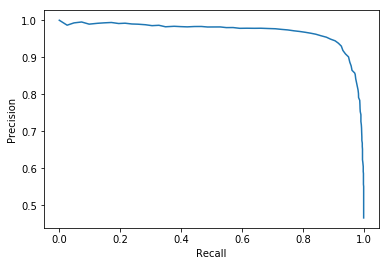

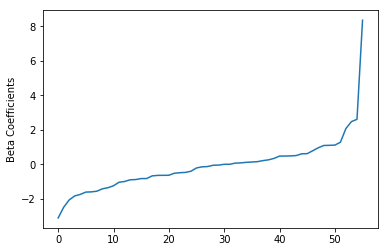

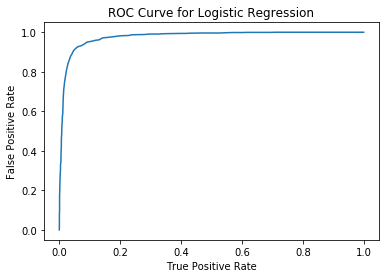

Confusion matrix for logistic regression:
[[747.  40.]
 [ 68. 683.]]


In [33]:
# logistic regression model building and analysis

from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

lrModel = lr.fit(train)

trainingSummary = lrModel.summary

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

print("")

# visualise example predictions

lrPreds = lrModel.transform(test)

lrPreds.select('word_freq_make', 'word_freq_000', 
               'word_freq_remove', 'char_freq_%24', 
               'rawPrediction', 'prediction', 'probability').show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()

print('Test Area Under ROC regression 10:', lrEval.evaluate(lrPreds))


# plot recall and precisions


lrROC = trainingSummary.roc.toPandas()


pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# plot roc 


plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()



# build confusion matrix

import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType


preds_and_labels = lrPreds.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')


preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("Confusion matrix for logistic regression:")

print(metrics.confusionMatrix().toArray())

In [34]:
# change parameters

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=1)

lrModel = lr.fit(train)

lrPreds = lrModel.transform(test)

lrEval = BinaryClassificationEvaluator()

print('Test Area Under ROC regression 1:', lrEval.evaluate(lrPreds))



Test Area Under ROC regression 1: 0.9371765219436383


In [35]:
# change parameters

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)

lrModel = lr.fit(train)

lrPreds = lrModel.transform(test)

lrEval = BinaryClassificationEvaluator()

print('Test Area Under ROC regression 5:', lrEval.evaluate(lrPreds))

Test Area Under ROC regression 5: 0.9624592030617383


In [38]:
# function for roc

from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
 
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [39]:
# build decision tree and analysis

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

dtModel = dt.fit(train)

dtPreds = dtModel.transform(test)

dtEval = BinaryClassificationEvaluator()

dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})

print("Test Area Under ROC decision tree max depth 3: " + str(dtROC))

dtModel.featureImportances

print(dtModel.toDebugString)


Test Area Under ROC decision tree max depth 3: 0.7537666846576442
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4d9d9da27345c362f80e) of depth 3 with 15 nodes
  If (feature 50 <= 0.073)
   If (feature 6 <= 0.04)
    If (feature 22 <= 0.0)
     Predict: 0.0
    Else (feature 22 > 0.0)
     Predict: 1.0
   Else (feature 6 > 0.04)
    If (feature 25 <= 0.0)
     Predict: 1.0
    Else (feature 25 > 0.0)
     Predict: 0.0
  Else (feature 50 > 0.073)
   If (feature 23 <= 0.17)
    If (feature 53 <= 10.0)
     Predict: 0.0
    Else (feature 53 > 10.0)
     Predict: 1.0
   Else (feature 23 > 0.17)
    If (feature 50 <= 0.692)
     Predict: 0.0
    Else (feature 50 > 0.692)
     Predict: 1.0



In [40]:
# change parameters

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5)

dtModel = dt.fit(train)

dtPreds = dtModel.transform(test)

dtEval = BinaryClassificationEvaluator()

dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})

print("Test Area Under ROC decision tree max depth 5: " + str(dtROC))

dtModel.featureImportances
# SparseVector(1, {0: 1.0}) 

Test Area Under ROC decision tree max depth 5: 0.8160698907175014


SparseVector(56, {4: 0.0018, 6: 0.1283, 8: 0.0027, 9: 0.0042, 14: 0.0058, 15: 0.0418, 16: 0.0159, 21: 0.0017, 22: 0.0483, 23: 0.1367, 25: 0.0243, 44: 0.0282, 50: 0.4659, 51: 0.0154, 53: 0.0791})

Test Area Under ROC decision tree max depth 10: 0.917462866114981


DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4794b5f77055ef59b48e) of depth 10 with 253 nodes
  If (feature 50 <= 0.073)
   If (feature 6 <= 0.04)
    If (feature 22 <= 0.0)
     If (feature 15 <= 0.1)
      If (feature 51 <= 0.173)
       If (feature 23 <= 0.0)
        If (feature 53 <= 10.0)
         If (feature 10 <= 0.21)
          If (feature 54 in {1.0,2.0})
           If (feature 0 <= 0.0)
            Predict: 1.0
           Else (feature 0 > 0.0)
            Predict: 0.0
          Else (feature 54 not in {1.0,2.0})
           If (feature 20 <= 0.51)
            Predict: 0.0
           Else (feature 20 > 0.51)
            Predict: 0.0
         Else (feature 10 > 0.21)
          If (feature 4 <= 0.0)
           Predict: 0.0
          Else (feature 4 > 0.0)
           Predict: 1.0
        Else (feature 53 > 10.0)
         If (feature 4 <= 0.65)
          If (feature 34 <= 0.21)
           If (featur

Confusion matrix for decision tree:
[[754.  33.]
 [ 57. 694.]]


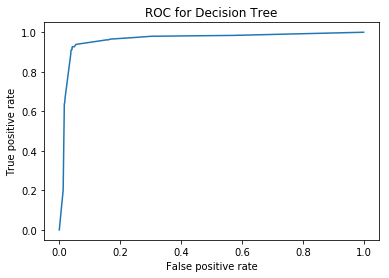

In [41]:
# change parameters and plot roc and confusion matrix

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)

dtModel = dt.fit(train)

dtPreds = dtModel.transform(test)

dtEval = BinaryClassificationEvaluator()

dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})

print("Test Area Under ROC decision tree max depth 10: " + str(dtROC))

print("")

dtModel.featureImportances

print("")

print(dtModel.toDebugString)

results = dtPreds.select(['probability', 'label'])

results_collect = results.collect()

preds = results.rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC for Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(x_val, y_val)



# #important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = dtPreds.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("Confusion matrix for decision tree:")

print(metrics.confusionMatrix().toArray())

In [42]:
# random forest

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = 10, maxDepth = 10)

rfModel = rf.fit(train)

rfPreds = rfModel.transform(test)

rfEval = BinaryClassificationEvaluator()

rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})

print("Test Area Under ROC for random forest 10: " + str(rfROC))

rfModel.featureImportances

Test Area Under ROC for random forest 10: 0.9903855426986813


SparseVector(56, {0: 0.0034, 1: 0.0017, 2: 0.0035, 3: 0.0005, 4: 0.0582, 5: 0.0019, 6: 0.0582, 7: 0.0024, 8: 0.0019, 9: 0.0027, 10: 0.0048, 11: 0.0061, 12: 0.0025, 13: 0.0015, 14: 0.0028, 15: 0.1268, 16: 0.0076, 17: 0.0019, 18: 0.0108, 19: 0.0159, 20: 0.0161, 21: 0.0244, 22: 0.0695, 23: 0.0827, 24: 0.0364, 25: 0.0364, 26: 0.0029, 27: 0.0053, 28: 0.0023, 29: 0.0006, 31: 0.0011, 32: 0.0022, 33: 0.0024, 34: 0.0026, 35: 0.0177, 36: 0.0009, 37: 0.0018, 38: 0.0003, 39: 0.0012, 40: 0.0119, 41: 0.0007, 42: 0.0029, 43: 0.0079, 44: 0.024, 45: 0.0001, 46: 0.0006, 47: 0.002, 48: 0.0055, 49: 0.0009, 50: 0.0893, 51: 0.1278, 52: 0.002, 53: 0.0829, 54: 0.0143, 55: 0.0053})

In [43]:
# different parameter setting

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = 50, maxDepth = 10)

rfModel = rf.fit(train)

rfPreds = rfModel.transform(test)

rfEval = BinaryClassificationEvaluator()

rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})

print("Test Area Under ROC for random forest 50: " + str(rfROC))

rfModel.featureImportances

Test Area Under ROC for random forest 50: 0.9909430374071339


SparseVector(56, {0: 0.0017, 1: 0.0025, 2: 0.0104, 3: 0.0003, 4: 0.0431, 5: 0.0055, 6: 0.0696, 7: 0.0091, 8: 0.0019, 9: 0.0046, 10: 0.0059, 11: 0.0051, 12: 0.0026, 13: 0.001, 14: 0.001, 15: 0.103, 16: 0.0096, 17: 0.0053, 18: 0.0133, 19: 0.0015, 20: 0.0491, 21: 0.0308, 22: 0.0508, 23: 0.0619, 24: 0.0281, 25: 0.0368, 26: 0.0031, 27: 0.0024, 28: 0.009, 29: 0.0017, 30: 0.0007, 31: 0.0012, 32: 0.0005, 33: 0.0044, 34: 0.0011, 35: 0.0116, 36: 0.0002, 37: 0.0042, 38: 0.0006, 39: 0.0017, 40: 0.006, 41: 0.0009, 42: 0.0018, 43: 0.0087, 44: 0.013, 45: 0.0001, 46: 0.0016, 47: 0.0026, 48: 0.0056, 49: 0.0019, 50: 0.1021, 51: 0.1668, 52: 0.0017, 53: 0.0603, 54: 0.0185, 55: 0.0115})

Test Area Under ROC for random forest 100: 0.9915859751589162
Confusion matrix for random forest:
[[771.  16.]
 [ 54. 697.]]


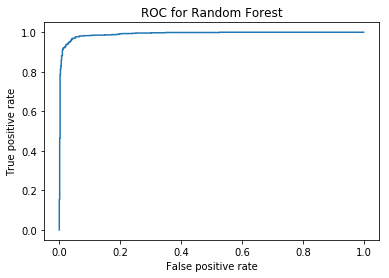

In [44]:
# different parameter setting

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = 100, maxDepth = 10)

rfModel = rf.fit(train)

rfPreds = rfModel.transform(test)

rfEval = BinaryClassificationEvaluator()

rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})

print("Test Area Under ROC for random forest 100: " + str(rfROC))

rfModel.featureImportances

results = rfPreds.select(['probability', 'label'])

results_collect = results.collect()

preds = results.rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC for Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(x_val, y_val)

preds_and_labels = rfPreds.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("Confusion matrix for random forest:")

print(metrics.confusionMatrix().toArray())